# Diffuse scattering integration with *mdx2*

In this tutorial, we will:

- Integrate diffuse scattering on a fractional Miller index grid
- Correct for geometry and background scattering

Requirements:
- `geometry.nxs` from the *mdx2* geometry tutorial
- `data.nxs`, `bkg_data_binned.nxs`, `mask.nxs` from the *mdx2* data tutorial

Imports (run this before you do anything else)

In [2]:
# for loading mdx2 objects in python
from mdx2.utils import loadobj

# for calculating statistics
import numpy as np
import pandas as pd

## 1) Integration

### *mdx2.integrate*

In [3]:
!mdx2.integrate --help

usage: mdx2.integrate [-h] [--mask MASK] [--subdivide N N N]
                      [--max_spread DEGREES] [--outfile OUTFILE]
                      geom data

Integrate counts in an image stack on a Miller index grid

positional arguments:
  geom                  NeXus file with miller_index
  data                  NeXus file with image_series

optional arguments:
  -h, --help            show this help message and exit
  --mask MASK           NeXus file with mask (default: None)
  --subdivide N N N     subdivisions of the Miller index grid (default: [1, 1,
                        1])
  --max_spread DEGREES  maximum angular spread for binning partial
                        observations (default: 1.0)
  --outfile OUTFILE     name of the output NeXus file (default:
                        integrated.nxs)


### Parameters

The main thing we need to decide is how to divide up reciprocal space into voxels. For the tutorial, I've chosen to subdivide by 4 in each direction, meaning voxels will be centered at h = 1, 1.25, 1.5, 1.75, etc. 

This is by no means the optimal choice: the limit depends on the mosaicity, experimental geometry, and most importantly what you hope to learn from the diffuse scattering map. You may want to experiment with other subdivisions. But beware that finer maps require a lot more memory and disk space.

Integration is the slowest step in data reduction. Be patient.

In [7]:
!mdx2.integrate geometry.nxs data.nxs --mask mask.nxs --subdivide 4 4 4

Reading miller_index from geometry.nxs
  importing as MillerIndex from mdx2.geometry
Reading image_series from data.nxs
  importing as ImageSeries from mdx2.data
Looping through chunks
  binned chunk 0 from 1891042 to 11799 voxels
  binned chunk 1 from 1891704 to 16089 voxels
  binned chunk 2 from 1891701 to 18091 voxels
  binned chunk 3 from 1891522 to 16321 voxels
  binned chunk 4 from 1891069 to 12286 voxels
  binned chunk 5 from 1890751 to 12084 voxels
  binned chunk 6 from 1891722 to 16991 voxels
  binned chunk 7 from 1891538 to 19162 voxels
  binned chunk 8 from 1891323 to 17110 voxels
  binned chunk 9 from 1891159 to 12590 voxels
  binned chunk 10 from 1891123 to 11731 voxels
  binned chunk 11 from 1891316 to 16922 voxels
  binned chunk 12 from 1891533 to 19300 voxels
  binned chunk 13 from 1891388 to 17004 voxels
  binned chunk 14 from 1891623 to 12171 voxels
  binned chunk 15 from 1891288 to 10482 voxels
  binned chunk 16 from 1891766 to 15408 voxels
  binned chunk 17 from 189

### Integration statistics

Integration produces a giant table indexed by fractional h,k,l values.

In [10]:
# load the table
tab = loadobj('integrated.nxs','hkl_table')

# convert to pandas dataframe
df = tab.to_frame().set_index(['h','k','l'])

# show the first several entries
df.head()

Reading hkl_table from integrated.nxs
  importing as HKLTable from mdx2.data


counts        ix        iy    n         phi  pixels  \
h     k      l                                                            
-65.5 -16.75 -9.75       2  0.333333  1.666667  0.0  160.449997       3   
             -9.50      12  0.869565  2.304348  0.0  160.250000      23   
             -9.25      15  1.892857  1.928571  0.0  160.078568      28   
      -16.50 -9.50       5  0.000000  6.166667  0.0  160.183334       6   
             -9.25       3  0.285714  6.857143  0.0  160.050003       7   

                    seconds  
h     k      l               
-65.5 -16.75 -9.75      0.3  
             -9.50      2.3  
             -9.25      2.8  
      -16.50 -9.50      0.6  
             -9.25      0.7

It is interesting to plot the number of observations as a function of spindle angle

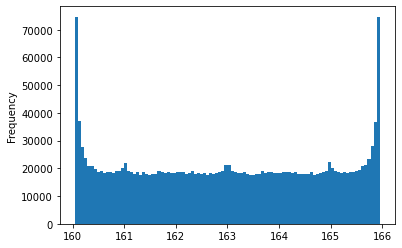

In [12]:
df['phi'].plot.hist(bins=100);

<div class="alert alert-block alert-info">
    <b>Question:</b> Why are there more observations at the beginning and end of the scan? (hint: think about partial observations)
</div>

## 2) Corrections

As explained in our 2020 Nature Communications paper , the intensity can be estimated as follows:

$I_\text{meas} = (r_\text{crystal} - r_\text{background})/(\Delta\Omega E A P)$

Where:
- $r_\text{crystal} =$ observed count rate (photons per second)
- $r_\text{background} =$ estimated count rate from background sources
- $\Delta\Omega =$ solid angle per pixel
- $E =$ detection efficiency
- $A =$ attenuation factor of air
- $P =$ polarization factor

*mdx2.correct* computes $I_\text{meas}$ using this equation.

Also, intensity errors are estimated using Poisson statistics:
- $r_\text{crystal} = N s^{-1}$ (counts per second)
- $\Delta r_\text{crystal} = \sqrt{N}s^{-1}$

### *mdx2.correct*

In [14]:
!mdx2.correct --help

usage: mdx2.correct [-h] [--background BACKGROUND] [--attenuation TF]
                    [--efficiency TF] [--polarization TF] [--outfile OUTFILE]
                    geom hkl

Apply corrections to integrated data

positional arguments:
  geom                  NeXus file with miller_index
  hkl                   NeXus file with hkl_table

optional arguments:
  -h, --help            show this help message and exit
  --background BACKGROUND
                        NeXus file with background map (default: None)
  --attenuation TF      apply attenuation correction? (default: True)
  --efficiency TF       apply efficiency correction? (default: True)
  --polarization TF     apply polarization correction? (default: True)
  --outfile OUTFILE     name of the output NeXus file (default: corrected.nxs)


### Parameters

The command line interface allows you to turn off certain corrections, such as background, attenuation, efficiency and polarization.

We'll apply all of them for the tutorial dataset.

For background count rate we'll use the binned image stack, so that the background subtraction does not add noise to the measurement.

In [27]:
!mdx2.correct geometry.nxs integrated.nxs --background bkg_data_binned.nxs

Reading hkl_table from integrated.nxs
  importing as HKLTable from mdx2.data
Reading corrections from geometry.nxs
  importing as Corrections from mdx2.geometry
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
calculating scattering vector magnitude (s)
mapping Miller indices to the asymmetric unit
Reading binned_image_series from bkg_data_binned.nxs
  importing as GridData from mdx2.geometry
subtracting background from count rate
correcting solid angle for attenuation
correcting solid angle for efficiency
correcting solid angle for polarization
computing the swept reciprocal space volume fraction (rs_volume)
computing intensity and intensity_error
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to corrected.nxs
done!


### Intensity statistics

As before, we'll load the table as a pandas DataFrame.

In addition to **intensity** and **intensity_error**, you'll notice there are some new columns.

- **op** = index of the symmetry operator that mapped the observation point to the asymmetric unit
- **h**, **k**, **l** = Miller indices mapped to the *asymmetric unit*
- **s** = scattering vector magnitude (= 1/resolution)
- **rs_volume** = volume of reciprocal space recorded as a fraction of the reciprocal unit cell

In our case, a voxel that is "fully recorded" during the oscillation would have rs_volume = (1/4^3)

In [3]:
# load table as mdx2 object
tab = loadobj('corrected.nxs','hkl_table')

# convert to pandas DataFrame
df = tab.to_frame().set_index(['h','k','l','op','n']).sort_index()

# show the first several rows
df.head()

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data


intensity  intensity_error           ix           iy  \
h   k    l     op n                                                          
0.0 0.25 2.75  10 0         NaN       3458472.25  1222.937500  1211.979126   
         3.00  10 0         NaN       4526965.50  1220.806396  1210.483887   
         3.25  10 0  38040624.0      19222264.00  1218.000000  1209.000000   
         19.75 10 0  55826468.0      25134906.00   958.000000  1023.750000   
         20.00 10 0  54929968.0      11178633.00   954.549988  1021.049988   

                            phi  rs_volume         s  
h   k    l     op n                                   
0.0 0.25 2.75  10 0  165.493744   0.000405  0.034724  
         3.00  10 0  165.672577   0.000274  0.037856  
         3.25  10 0  165.800003   0.000037  0.040990  
         19.75 10 0  165.949997   0.000209  0.248377  
         20.00 10 0  165.904999   0.001056  0.251520

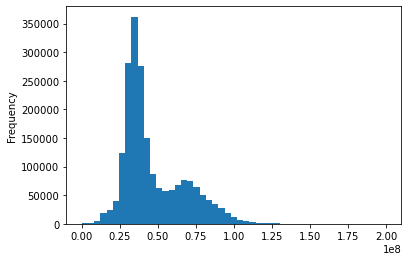

In [4]:
# plot intensity histogram
df['intensity'].plot.hist(bins=np.linspace(0,2E8));

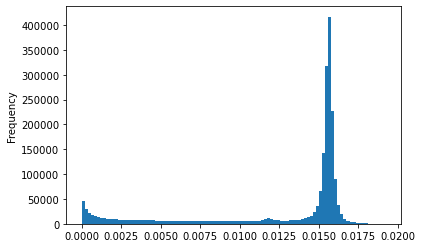

In [5]:
# plot fractional reciprocal space volume per observation
df['rs_volume'].plot.hist(bins=100);

In [31]:
# fractional volume of one voxel
1/4**3 # --subdivide 4 4 4

0.015625

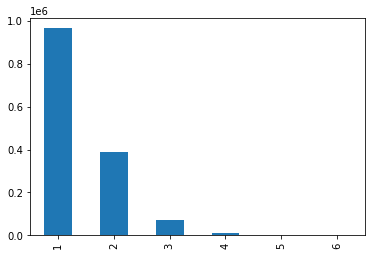

In [24]:
# redundancy of observations
c = df.groupby(['h','k','l'])['phi'].count().value_counts().sort_index()
c[c>1000].plot.bar();

<div class="alert alert-block alert-info">
    <b>Tip:</b> For more examples of using pandas to compute statistics, see the advanced python notebook (tutorial 6).
</div >

## Next steps

In order to make a reciprocal space map, we need to place all of the observations on the same scale and merge them. That will be the topic of the next tutorial in this series.

However, so far we've only processed 6 degrees of data (out of 50 total). As you can see from the bar plot above, most observations are unique. So there will not be enough redundant data to refine the scaling model. And the merged dataset will also be incomplete.

To proceed, you have 2 options (choose depending on your interest and time available):

<div class="alert alert-block alert-warning">
    <b>Option 1:</b> Re-run the tutorial notebooks 3-4 using the full dataset (refined.expt). This will take approximately 30 minutes to run. You can skip ahead and do tutorial 6 while you wait.
</div>

<div class="alert alert-block alert-warning">
    <b>Option 2:</b> Proceed to tutorial 5 using the corrected.nxs that was included in the GitHub release (this was pre-processed with the full 50 degrees of data).
</div>